## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'jet.bmp'

if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

In [2]:
def showHistGray(ax, image, title):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    ax.set_title(title)
    ax.grid()
    ax.plot(hist)
#
def showImageGray(ax, image, title):
    ax.set_title(title)
    ax.axis('off')
    ax.imshow(image, 'gray', vmin=0, vmax=256)
#
def showCumHistPlt(ax, image, title):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    cumHist = hist.cumsum()
    ax.title(title)
    ax.plot(hist / np.max(hist))
    ax.plot(cumHist / np.max(cumHist))

#
def showHistGrayPlt(ax, image, title):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    ax.plot(hist)
#
# Returns pointer to CLAHE class. 
def createCLAHE(contrastLimit, recRows, recColumns):
    return cv2.createCLAHE(contrastLimit, (recRows, recColumns))
#

def normalize(image):
    result = np.zeros(image.shape, dtype=np.uint8)
    cv2.normalize(image, result, 0, 255, cv2.NORM_MINMAX)
    return result 
#

def show3Img(ax, image):
    imageCLAHE    = clahe.apply(image)
    imageNORM     = normalize(image) 
    imageEqualize = cv2.equalizeHist(image)

    showImageGray(ax[0], image, "Original image")
    showImageGray(ax[1], imageCLAHE, "Image CLAHE")
    showImageGray(ax[2], imageNORM, "Image NORMALIZE")
    showImageGray(ax[3], imageEqualize, "Image Equalize")
#
def showHistColor(ax, image, channel, title):
    hist = cv2.calcHist([image], [channel], None, [256], [0, 256])
    ax.set_title(title)
    ax.grid()
    ax.plot(hist)
#
def showImageColor(ax, image, title):
    ax.set_title(title)
    ax.axis('off')
    ax.imshow(image, vmin=0, vmax=256)
#

clahe = createCLAHE(5, 5, 5)

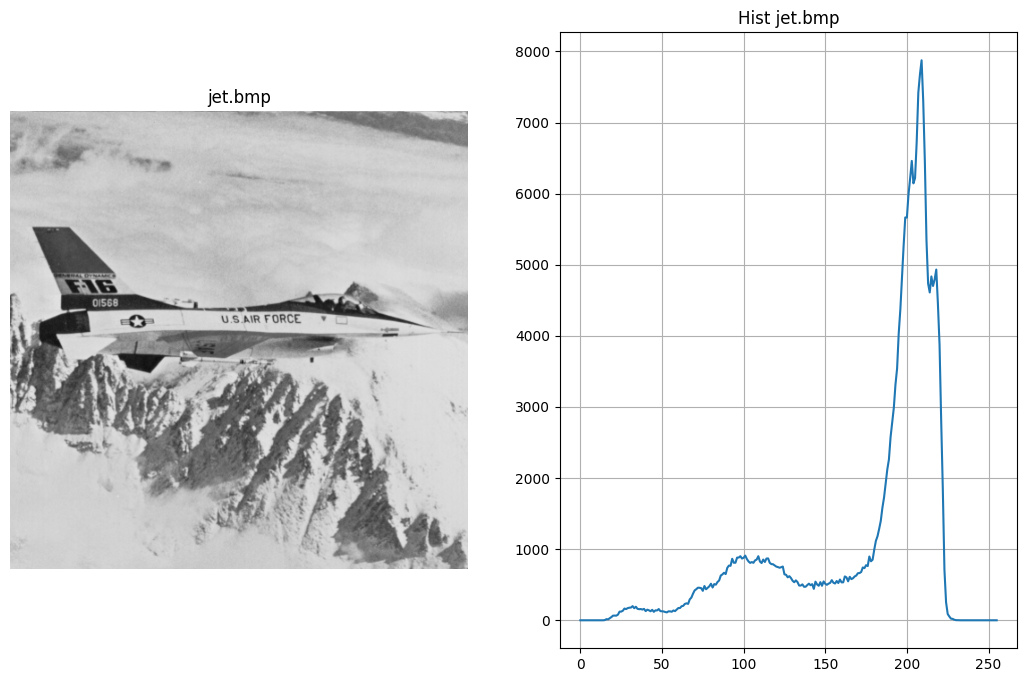

In [3]:
jet = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)
_, axs = plt.subplots(1, 2, figsize=(13, 8))

showImageGray(axs[0], jet, "jet.bmp")
showHistGray(axs[1], jet, "Hist jet.bmp")

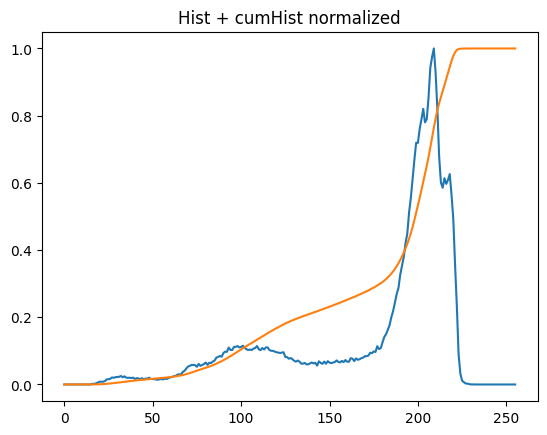

In [4]:
showCumHistPlt(plt, jet, "Hist + cumHist normalized")

In [5]:
jet.shape

(512, 512)

In [6]:
def BBHE(image):
    lm = int(np.median(image))
    H = cv2.calcHist([image], [0], None, [256], [0, 256])
    
    cumLowerH = np.cumsum(H[:lm + 1])
    cumUpperH = np.cumsum(H[lm + 1:])

    cumLowerH = cumLowerH / np.max(cumLowerH)
    cumUpperH = cumUpperH / np.max(cumUpperH)

    lowerLUT = cumLowerH * lm 
    upperLUT = cumUpperH * (255 - lm - 1) + lm + 1 

    LUT = np.concatenate((lowerLUT, upperLUT)).astype(np.uint8)
    return LUT
#

In [10]:
def showBBHE(image):
    imageEqualize = cv2.equalizeHist(image)
    imageBBHE = cv2.LUT(jet, BBHE(jet))

    _, axs = plt.subplots(1, 3, figsize=(16, 10))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Oryginalny")

    axs[1].imshow(imageEqualize, cmap='gray')
    axs[1].set_title("Equalize")

    axs[2].imshow(imageBBHE, cmap='gray')
    axs[2].set_title("BBHE")

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
#

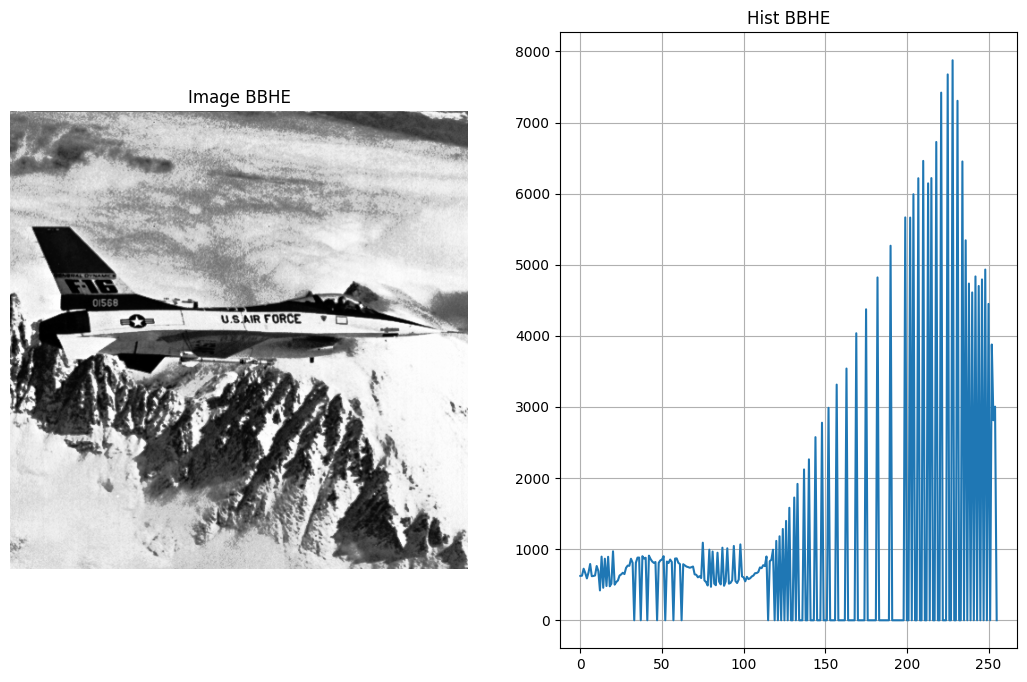

In [14]:
_, axs = plt.subplots(1, 2, figsize=(13, 8))

imageEqualize = cv2.equalizeHist(jet)
imageBBHE = cv2.LUT(jet, BBHE(jet))

showImageGray(axs[0], imageBBHE, "Image BBHE")
showHistGray(axs[1], imageBBHE, "Hist BBHE")

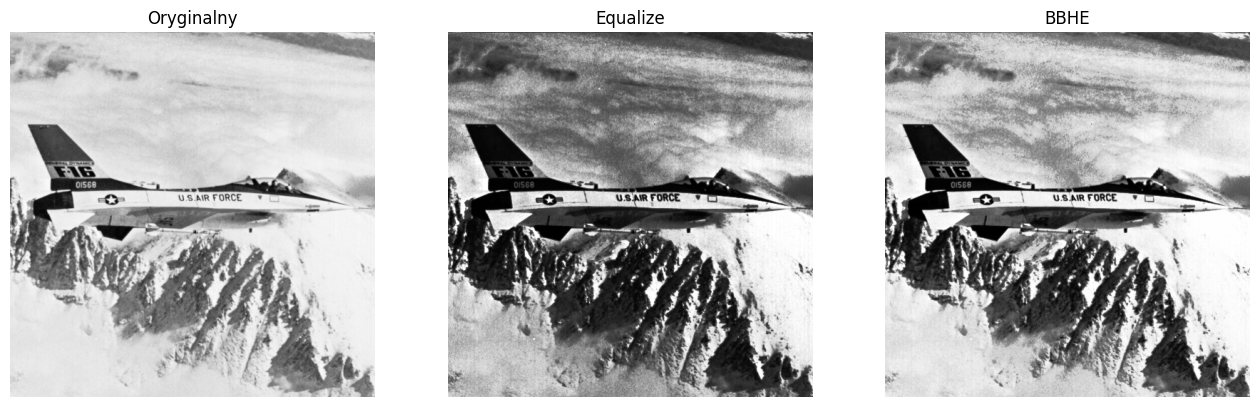

In [11]:
showBBHE(jet)